<a href="https://colab.research.google.com/github/mypham14/merchant-commission-anomaly-detection/blob/main/ATX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Data Processing

In [ ]:
# Import data from my drive

from google.colab import drive
# drive.mount('/content/drive')
import pandas as pd

hoahong = pd.read_csv('/content/drive/MyDrive/ATX/hoahong1.csv')
hoahong.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


createdAt  merchantId  receiveAmount  receiveAssetId  \
0  2024-11-30T17:00:58.076Z    80254491      69.815873             617   
1  2024-11-30T17:00:57.595Z    49465688      65.847413             617   
2  2024-11-30T17:01:54.309Z    13853662     609.360535             617   
3  2024-11-30T17:02:42.391Z    13853662     224.399319             617   
4  2024-11-30T17:03:10.455Z    13853662      99.881955             617   

               tag  
0  YY0OYzLMrAeVNr3  
1  buQtvjpx48ob1cb  
2  Lm3L6U3OWBGS7cw  
3  2xSzEvmH1lRh1Ac  
4  ZZbEqEI4D7xl-VV

In [ ]:
merchant = pd.read_csv("/content/drive/MyDrive/ATX/merchant and dob.csv")
merchant.head()

dob  merchantId
0  01-01-1995       10000
1  19-05-2002    61311010
2  15-03-1999    61012073
3  25-07-1989    82119069
4  03-06-1998    73615099

In [ ]:
merchant.dtypes

dob           object
merchantId     int64
dtype: object

In [ ]:
# !pip install pandasql

In [ ]:
# SQL queries using SQLite

import pandasql as ps

# Commission paid to each merchant (assume 1 USD = 20,000 VND)
query = """
select createdAt, merchantId, sum(
       case when receiveAssetId = 20 then receiveAmount*20000
            when receiveAssetId = 617 then receiveAmount
            else 0
       end) as commissionAmount
from hoahong
where receiveAssetId in (20, 617)
and createdAt like '2024-12%'
group by 1,2
order by 1;
"""

q1 = ps.sqldf(query, locals())
q1

createdAt  merchantId  commissionAmount
0      2024-12-01T00:01:18.490Z    17337397        125.092285
1      2024-12-01T00:03:58.631Z    85211695       2874.026540
2      2024-12-01T00:05:53.861Z    80815585          0.006380
3      2024-12-01T00:07:54.585Z    50499771       1227.771832
4      2024-12-01T00:07:55.066Z    50499771       2532.889436
...                         ...         ...               ...
63687  2024-12-31T23:43:49.675Z    17337397          0.888690
63688  2024-12-31T23:43:59.861Z    17337397          0.436310
63689  2024-12-31T23:44:04.440Z    80254491       1629.792889
63690  2024-12-31T23:48:59.086Z    89942363         20.027617
63691  2024-12-31T23:50:36.265Z    89942363         92.303896

[63692 rows x 3 columns]

In [ ]:
# Which day of the week and time of the day have the highest amount received?

query = """
select case cast(strftime('%w', createdAt) as integer)
            when 0 then 'Sunday'
            when 1 then 'Monday'
            when 2 then 'Tuesday'
            when 3 then 'Wednesday'
            when 4 then 'Thursday'
            when 5 then 'Friday'
            else 'Saturday' end as dayOfWeek,
       strftime('%H', createdAt) as hourOfDay,
       sum(
       case when receiveAssetId = 20 then receiveAmount*20000
            when receiveAssetId = 617 then receiveAmount
            else 0
       end) as commissionAmount
from hoahong
where receiveAssetId in (20, 617)
--and createdAt like '2024-12%'
group by 1,2
order by 3 desc limit 1;
"""

q2 = ps.sqldf(query, locals())
q2


dayOfWeek hourOfDay  commissionAmount
0   Tuesday        11      1.302278e+06

In [ ]:
# How many merchants per day receive commission for the first time during the month?

query = """
select date(createdAt) commissionDt, count(distinct merchantId) as newMerchants
from
  (select createdAt, merchantId, min(createdAt) over (partition by merchantId) as firstDt from hoahong) f
where commissionDt = date(f.firstDt)
group by 1
order by 1;
"""

q3 = ps.sqldf(query, locals())
q3

commissionDt  newMerchants
0    2024-11-30            72
1    2024-12-01           169
2    2024-12-02           108
3    2024-12-03            82
4    2024-12-04            64
5    2024-12-05            59
6    2024-12-06            33
7    2024-12-07            24
8    2024-12-08            27
9    2024-12-09            30
10   2024-12-10            35
11   2024-12-11            22
12   2024-12-12            24
13   2024-12-13            14
14   2024-12-14             9
15   2024-12-15            18
16   2024-12-16            13
17   2024-12-17            13
18   2024-12-18            19
19   2024-12-19            22
20   2024-12-20            22
21   2024-12-21             7
22   2024-12-22             9
23   2024-12-23             7
24   2024-12-24            17
25   2024-12-25            13
26   2024-12-26            12
27   2024-12-27             9
28   2024-12-28            12
29   2024-12-29             6
30   2024-12-30            11
31   2024-12-31             4
32   2025-01-01             6

In [ ]:
# Average merchant age and age with highest amount
query = """
select strftime('%Y', 'now') - avg(substr(dob,-4)) as avgAge,
       (select age from
               (select strftime('%Y', 'now') - substr(dob,-4) as age,
                  sum(case when receiveAssetId = 20 then receiveAmount*20000
                            when receiveAssetId = 617 then receiveAmount
                            else 0
                            end) as commissionAmount
                  from hoahong h
                  join merchant m on h.merchantId = m.merchantId
                  where receiveAssetId in (20, 617)
                  group by 1
                  order by 2 desc
                  limit 1)
       ) ageHighestAmount
from merchant;
"""

q4 = ps.sqldf(query, locals())
q4

avgAge  ageHighestAmount
0  31.884337                32

#2. Data Visualization

In [ ]:
# Convert receiveAmount to VND for the entire table
query = """
select *, case when receiveAssetId = 20 then receiveAmount*20000
          when receiveAssetId = 617 then receiveAmount
          else 0
          end as commissionAmount
from hoahong;
"""

hh = ps.sqldf(query, locals())
hh.head()

createdAt  merchantId  receiveAmount  receiveAssetId  \
0  2024-11-30T17:00:58.076Z    80254491      69.815873             617   
1  2024-11-30T17:00:57.595Z    49465688      65.847413             617   
2  2024-11-30T17:01:54.309Z    13853662     609.360535             617   
3  2024-11-30T17:02:42.391Z    13853662     224.399319             617   
4  2024-11-30T17:03:10.455Z    13853662      99.881955             617   

               tag  commissionAmount  
0  YY0OYzLMrAeVNr3         69.815873  
1  buQtvjpx48ob1cb         65.847413  
2  Lm3L6U3OWBGS7cw        609.360535  
3  2xSzEvmH1lRh1Ac        224.399319  
4  ZZbEqEI4D7xl-VV         99.881955

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Data preparation
hh['createdAt'] = pd.to_datetime(hh['createdAt'])
hh['Year'] = hh['createdAt'].dt.year
hh['Month'] = hh['createdAt'].dt.month
hh['weekday'] = hh['createdAt'].dt.day_name()
hh['hour'] = hh['createdAt'].dt.hour

merchant['age'] = pd.to_datetime('today').year - pd.to_datetime(merchant['dob'], errors='coerce').dt.year
merchant['age_group'] = pd.cut(merchant['age'], bins=[18, 25, 35, 45, 55, 65, float('inf')],
                               labels=['18-24', '25-34', '35-44', '45-54', '55-64', '65+'])


# Dashboard function
def create_dashboard(hh_df, merchant_df):

    # Create subplots for the dashboard
    # The 'rows' and 'cols' are defined here in make_subplots
    fig = make_subplots(rows=3, cols=2,  # Define rows and cols for the grid
                        subplot_titles=("Daily Commission Trend", "Commission by Weekday",
                                        "Commission Heatmap", "Avg Commission vs. Avg Frequency",
                                        "Age Histogram", "Total Commission per Age Group"),  # Titles for subplots
                        vertical_spacing=0.15, horizontal_spacing=0.1)

    # Chart 1: Daily Commission Trend with Trendline (blue color)
    daily_commission = hh_df.groupby('createdAt')['commissionAmount'].sum().reset_index()
    fig.add_trace(go.Scatter(x=daily_commission['createdAt'], y=daily_commission['commissionAmount'],
                             mode='lines+markers', name='Daily Commission', showlegend=False), row=1, col=1) # Remove legend
    fig.add_trace(go.Scatter(x=daily_commission['createdAt'], y=daily_commission['commissionAmount'].rolling(window=7).mean(),
                             mode='lines', name='Trendline', line=dict(color='blue'), showlegend=False), row=1, col=1) # Blue color, remove legend

    # Chart 2: Total Commission by Weekday (remove legend)
    weekday_commission = hh_df.groupby('weekday')['commissionAmount'].sum().reset_index()
    fig.add_trace(go.Bar(x=weekday_commission['weekday'], y=weekday_commission['commissionAmount'],
                         name='Commission by Weekday', showlegend=False), row=1, col=2) # Remove legend

    # Chart 3: Heatmap of Commission by Weekday and Hour (remove color bar)
    heatmap_data = hh_df.groupby(['weekday', 'hour'])['commissionAmount'].sum().reset_index()
    fig.add_trace(go.Heatmap(z=heatmap_data['commissionAmount'], x=heatmap_data['weekday'],
                             y=heatmap_data['hour'], colorscale='Viridis',
                             showscale=False, name='Commission Heatmap', showlegend=False), # Remove color bar and legend
                  row=2, col=1)

    # Chart 4: Avg Commission vs. Avg Frequency Scatter Plot (remove legend)
    merchant_stats = hh_df.groupby('merchantId').agg(
        avg_commission=('commissionAmount', 'mean'),
        avg_frequency=('createdAt', 'count')  # Frequency is the count of transactions
    ).reset_index()
    fig.add_trace(go.Scatter(x=merchant_stats['avg_commission'], y=merchant_stats['avg_frequency'],
                             mode='markers', name='Avg Commission vs. Avg Frequency',
                             hovertext=merchant_stats['merchantId'], showlegend=False),  # Show merchantId on hover, remove legend
                  row=2, col=2) # Remove legend

    # Chart 5: Age Histogram
    fig.add_trace(go.Histogram(x=merchant_df['age'], nbinsx=10, name='Age Histogram', showlegend=False), row=3, col=1)

    # Chart 6: Total Commission per Age Group
    # Merge the dataframes based on 'merchantId'
    merged_df = pd.merge(hh_df, merchant_df, on='merchantId', how='left')
    # Group by age group and sum commission amount
    age_group_commission = merged_df.groupby('age_group')['commissionAmount'].sum().reset_index()

    fig.add_trace(go.Bar(x=age_group_commission['age_group'],
                         y=age_group_commission['commissionAmount'],
                         name='Total Commission per Age Group', showlegend=False), row=3, col=2)


    # Update layout
    fig.update_layout(height=1000, width=1200,  # Increased height
                      title_text="<b>MERCHANT COMMISSION DASHBOARD</b>",
                      title_x=0.5,
                      title_font=dict(size=24)
                      # No need to specify 'rows' and 'cols' here
                     )

    fig.show()

# Call the dashboard function
create_dashboard(hh, merchant)

<ipython-input-100-c886554bc1e7>:64: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



#3. Data Analysis and Processing

**Observations and Insights:**

* **Commission Analysis:** December has several significant high amounts. There are also multiple merchants that are outliers in the scatter plot, indicating that they have a higher average frequency of transactions or a higher average commission amount.

* **User Demographics (Merchant Focus):** The most frequent age groups are 20-29 and 30-39, while the groups with the highest amounts are 18-24 and 35-44.

* **Transaction Behavior:** Wednesday and Monday have the highest commissions out of the whole week. Weekend evenings (after 20:00) tend to have higher commission amounts.

**Marketing Recommendations:**

1. **Targeted Promotions Based on Time:**  The analysis of commission amounts by day and time suggests optimal times to run promotions. Focusing promotions over the weekends especially in the evening when commission revenue is naturally higher could increase overall transaction volume.

2. **Incentivize New Merchants:** Given the analysis of new merchants, consider onboarding incentives (e.g., reduced fees or bonus commissions) during periods when new merchant acquisition is lower and focus on promoting the platform's benefits to encourage signup.

3. **Age-Based Promotions:** The age groups with the highest commission amount tend to be younger, so we should consider tailored promotions to that demographic. Since younger merchants show more engagement in specific areas, we can design promotions based on these insights.

4. **Loyalty Programs:** Develop tiered loyalty programs that reward frequent transactions and high commission amounts. This could boost user retention and overall activity.

5. **A/B Testing:** Instead of relying on assumptions, we should conduct an A/B test with different promotional strategies (e.g., different discount levels, timing, promotion types) to determine what resonates most with specific user segments.

**Commission/Fee Strategy:**

Blindly reducing fees to increase user volume is risky. Here are some alternatives:

1. **Tiered Fees:** Offer tiered transaction fees based on transaction volume or merchant loyalty. Higher transaction volume/loyalty earns lower fees, making it more attractive for high-volume merchants. This can benefit the platform, merchants, and users.

2. **Value-Added Services:** Instead of solely competing on price, differentiate the platform by offering value-added services (e.g., enhanced marketing tools, analytics dashboards, customer support). These services can justify slightly higher fees while adding value for merchants.

3. **Performance-Based Fees:** Tie commission rates to specific performance goals. For example, offer higher commission rates for merchants who achieve higher customer satisfaction ratings or conversion rates. This aligns incentives and helps promote positive customer interactions.

4. **Negotiated Fees:** For large or strategic merchant partners, consider offering negotiated fees. This can build strong relationships and secure key partnerships.

**Additional Analysis:**

* **Missing data:** Examine the data for missing values and consider imputation techniques if appropriate.

* **Correlation analysis:** Further explore correlations between different variables (e.g., merchant age, transaction amount, transaction time) to reveal more detailed relationships.

With carefully examination of user and merchant behavior patterns and thoughtfully adjusting commission and fee structures, the platform can optimize the balance between revenue generation and user/merchant satisfaction.

#4. Anomaly Detection

## Using Z-Score

**Z-score (a standard score):** measures how many standard deviations a data point is away from the mean of a distribution. In anomaly detection, Z-scores are used to identify data points that are significantly different from the rest of the data. These data points are considered potential anomalies or outliers.

$Z = (X - μ) / σ$

Where:
*   X: individual data point
*   μ: mean of the distribution
*   σ: standard deviation of the distribution

**Interpretation:** The magnitude of the Z-score represents the distance from the mean in terms of standard deviations.
* Z=0: the data point is equal to the mean
* Z>0: the data point is above the mean
* Z<0: the data point is below the mean

**Empirical Rule (68-95-99.7 Rule):** In a normal distribution, approximately 68% of data points fall within 1 standard deviation of the mean, 95% within 2 standard deviations, and 99.7% within 3 standard deviations.

**Outlier Identification:** Data points with a Z-score greater than 3 (or less than -3) are considered outliers because they fall outside the range where 99.7% of the data is expected to lie. These extreme values are likely to be anomalies.
Thus, 3 is a common choice as the threshold to determine anomalies.

**Balance Between Sensitivity and Specificity:** Setting the threshold to 3 strikes a good balance between identifying genuine anomalies (sensitivity) and avoiding too many false positives (specificity).

**Practical Consideration:** While a higher threshold (e.g., 4 or 5) would further reduce false positives, it might miss some real anomalies. A lower threshold (e.g., 2) would increase sensitivity but could lead to more false alarms.

###Commission Amount

In [ ]:
# Calculate Z-scores for commission amounts
from scipy import stats

def detect_anomalies(df,threshold):
    df['zscore'] = df.groupby('merchantId')['commissionAmount'].transform(lambda x: stats.zscore(x))
    # Identify anomalies based on Z-score threshold (e.g., |Z-score| > 3)
    df['anomaly_amount'] = df['zscore'].abs() > threshold # True: anomaly, False: not anomaly
    return df

# Test results with thresholds of 4 and 5
result = detect_anomalies(hh,4)
result['anomaly_amount'].value_counts()

anomaly_amount
False    64647
True       744
Name: count, dtype: int64

In [ ]:
# Threshold = 3
result = detect_anomalies(hh,3)
result['anomaly_amount'].value_counts()

anomaly_amount
False    64135
True      1256
Name: count, dtype: int64

In [ ]:
# Show results
result.head(10)

createdAt  merchantId  receiveAmount  receiveAssetId  \
0   2024-11-30T17:00:58.076Z    80254491      69.815873             617   
1   2024-11-30T17:00:57.595Z    49465688      65.847413             617   
2   2024-11-30T17:01:54.309Z    13853662     609.360535             617   
3   2024-11-30T17:02:42.391Z    13853662     224.399319             617   
4   2024-11-30T17:03:10.455Z    13853662      99.881955             617   
5   2024-11-30T17:05:01.737Z    71584120     246.778594             617   
6   2024-11-30T17:05:05.086Z    18459099       0.051658              20   
7   2024-11-30T17:05:36.629Z    71584120     191.658645             617   
8   2024-11-30T17:09:40.086Z    20788296    2043.672700             617   
9   2024-11-30T17:11:12.533Z    20788296      85.144902             617   
10  2024-11-30T17:11:43.272Z    71584120     164.986785             617   
11  2024-11-30T17:12:04.237Z    71584120      89.878200             617   
12  2024-11-30T17:12:34.451Z    20788296     478.849580             617   
13  2024-11-30T17:13:53.903Z    33341575    1358.935500             617   
14  2024-11-30T17:14:12.629Z    80254491    1229.568580             617   
15  2024-11-30T17:14:52.512Z    33341575       5.782557             617   
16  2024-11-30T17:16:51.426Z    71584120    4545.243971             617   
17  2024-11-30T17:19:00.107Z    33341575    3973.677762             617   
18  2024-11-30T17:20:42.318Z    49465688     138.172502             617   
19  2024-11-30T17:20:41.776Z    59727553      61.776344             617   

                tag  commissionAmount    zscore  anomaly_amount  
0   YY0OYzLMrAeVNr3         69.815873 -0.248262           False  
1   buQtvjpx48ob1cb         65.847413 -0.326616           False  
2   Lm3L6U3OWBGS7cw        609.360535  0.754659           False  
3   2xSzEvmH1lRh1Ac        224.399319 -0.067211           False  
4   ZZbEqEI4D7xl-VV         99.881955 -0.333048           False  
5   ElTRhsprsugDyZu        246.778594 -0.322790           False  
6   LVOOWptXqpsvhBX       1033.168000  0.866934           False  
7   OTy7ptoHx55hvgo        191.658645 -0.335394           False  
8   OBUFeVBivg4S_WV       2043.672700  0.585533           False  
9   7ZR40Dwb_mzBHDf         85.144902 -0.237991           False  
10  pmrCEch-Y78h-mj        164.986785 -0.341492           False  
11  uvIoZEsiaK9hSvu         89.878200 -0.358666           False  
12  m_mEacjJ2I7fnFo        478.849580 -0.072446           False  
13  5obTrkL54zJT2eS       1358.935500  0.093356           False  
14  JBfyhZBslzQZQOj       1229.568580 -0.050804           False  
15  qfMd9BZVmqswrFv          5.782557 -0.232811           False  
16  jfIIIQB9c6udeLg       4545.243971  0.660051           False  
17  TNIXn8bpTCSauL2       3973.677762  0.723619           False  
18  lBuv1cOGLoapJD5        138.172502 -0.309641           False  
19  BzRWYyJMtETcDo1         61.776344 -0.558655           False

###Frequency of Transactions

In [ ]:
# Calculate Z-scores for frequency of transactions
def detect_frequency_anomalies(df, time_window, threshold):
    # Convert 'createdAt' to datetime
    df['createdAt'] = pd.to_datetime(df['createdAt'])
    # Group transactions by merchant and time window
    df['transaction_count'] = df.groupby(['merchantId', pd.Grouper(key='createdAt', freq=time_window)])['commissionAmount'].transform('count')
    # Calculate the rolling mean and standard deviation of 7 transaction counts (weekly pattern) within the window
    df['rolling_mean'] = df.groupby('merchantId')['transaction_count'].transform(lambda x: x.rolling(window=7, center=True).mean())
    df['rolling_std'] = df.groupby('merchantId')['transaction_count'].transform(lambda x: x.rolling(window=7, center=True).std())
    # Calculate the Z-score for transaction counts
    df['zscore_freq'] = (df['transaction_count'] - df['rolling_mean']) / df['rolling_std']
    # Identify anomalies based on Z-score threshold (e.g., |Z-score| > 2)
    df['anomaly_frequency'] = df['zscore_freq'].abs() > threshold
    return df

# Test different values for time_window (1H, 2H, 3H, 6H, 9H) and threshold (2,3) to select the best balance
result = detect_frequency_anomalies(hh,'3H',2)
result.anomaly_frequency.value_counts()

<ipython-input-41-49ea5c2814e6>:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['transaction_count'] = df.groupby(['merchantId', pd.Grouper(key='createdAt', freq=time_window)])['commissionAmount'].transform('count')


anomaly_frequency
False    65103
True       288
Name: count, dtype: int64

In [ ]:
result = detect_frequency_anomalies(hh,'6H',2)
result.tail(10)

<ipython-input-41-49ea5c2814e6>:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['transaction_count'] = df.groupby(['merchantId', pd.Grouper(key='createdAt', freq=time_window)])['commissionAmount'].transform('count')


createdAt  merchantId  receiveAmount  \
65381 2025-01-01 16:49:51.288000+00:00    74356724       0.000735   
65382 2025-01-01 16:50:09.582000+00:00    74356724       0.000341   
65383 2025-01-01 16:50:09.496000+00:00    74356724       0.000364   
65384 2025-01-01 16:50:40.469000+00:00    74356724       0.003439   
65385 2025-01-01 16:50:40.524000+00:00    74356724       0.020217   
65386 2025-01-01 16:50:40.419000+00:00    74356724       0.001535   
65387 2025-01-01 16:52:26.679000+00:00    91437898     302.543360   
65388 2025-01-01 16:52:31.802000+00:00    72851676      54.986010   
65389 2025-01-01 16:53:09.710000+00:00    49465688     527.898782   
65390 2025-01-01 16:53:09.647000+00:00    74356724     480.789381   

       receiveAssetId              tag  commissionAmount    zscore  \
65381              20  X1sXAnR0yZJmohO         14.704800 -0.231687   
65382              20  3SObql-c8vfxdCv          6.826800 -0.234724   
65383              20  U4rB-3pIndNuQkx          7.286800 -0.234547   
65384              20  7z05YjiHYY3fHo5         68.776000 -0.210845   
65385              20  wUDnGZ43l1xNjlk        404.349000 -0.081494   
65386              20  nBeWc2HZIuHVRd-         30.700600 -0.225522   
65387             617  OJv63UNoRnoBVRb        302.543360 -0.567003   
65388             617  DSJf1FYzDgOkDM2         54.986010 -0.283270   
65389             617  -787FB7n1k3u_qi        527.898782 -0.218171   
65390             617  2vnr-GQDUgdqFVT        480.789381 -0.052029   

       anomaly_amount  transaction_count  rolling_mean  rolling_std  \
65381           False                  9      9.285714     0.755929   
65382           False                  9      9.000000     0.000000   
65383           False                  9      9.000000     0.000000   
65384           False                  9      9.000000     0.000000   
65385           False                  9           NaN          NaN   
65386           False                  9           NaN          NaN   
65387           False                  1           NaN          NaN   
65388           False                  6           NaN          NaN   
65389           False                 58           NaN          NaN   
65390           False                  9           NaN          NaN   

       zscore_freq  anomaly_frequency  
65381    -0.377964              False  
65382          NaN              False  
65383          NaN              False  
65384          NaN              False  
65385          NaN              False  
65386          NaN              False  
65387          NaN              False  
65388          NaN              False  
65389          NaN              False  
65390          NaN              False

A 6-hour window with a threshold of 2 provides a reasonable balance between capturing short-term fluctuations in transaction frequency and identifying meaningful patterns. It is short enough to detect sudden spikes in activity but not so short that it becomes overly sensitive to random noise.

Choosing a smaller window (e.g., 1 hour) could lead to more frequent anomalies, potentially increasing false positives. A larger window (e.g., 12 hours or 24 hours) might miss subtle but significant changes in frequency.

###Time of Day

In [ ]:
# Anomaly detection for time of day
def detect_time_anomalies(df,hour):
    # Extract hour of day from 'createdAt'
    df['hour'] = pd.to_datetime(df['createdAt']).dt.hour
    # Calculate the average hour of transactions for each merchant
    average_hour = df.groupby('merchantId')['hour'].mean().to_dict()
    df['average_hour'] = df['merchantId'].map(average_hour)
    df['hour_diff'] = abs(df['hour'] - df['average_hour'])
    # Define a threshold for unusual transaction hours (e.g., more than 12 hours difference)
    df['anomaly_time'] = df['hour_diff'] > hour
    return df

# Test values for hour (3,5,6,8,9,12)
result = detect_time_anomalies(hh,8)
result['anomaly_time'].value_counts()

anomaly_time
False    50528
True     14863
Name: count, dtype: int64

In [ ]:
result = detect_time_anomalies(hh,12)
result.head()

createdAt  merchantId  receiveAmount  receiveAssetId  \
0 2024-11-30 17:00:58.076000+00:00    80254491      69.815873             617   
1 2024-11-30 17:00:57.595000+00:00    49465688      65.847413             617   
2 2024-11-30 17:01:54.309000+00:00    13853662     609.360535             617   
3 2024-11-30 17:02:42.391000+00:00    13853662     224.399319             617   
4 2024-11-30 17:03:10.455000+00:00    13853662      99.881955             617   

               tag  commissionAmount    zscore  anomaly_amount  \
0  YY0OYzLMrAeVNr3         69.815873 -0.248262           False   
1  buQtvjpx48ob1cb         65.847413 -0.326616           False   
2  Lm3L6U3OWBGS7cw        609.360535  0.754659           False   
3  2xSzEvmH1lRh1Ac        224.399319 -0.067211           False   
4  ZZbEqEI4D7xl-VV         99.881955 -0.333048           False   

   transaction_count  rolling_mean  rolling_std  zscore_freq  \
0                  2           NaN          NaN          NaN   
1                  7           NaN          NaN          NaN   
2                  3           NaN          NaN          NaN   
3                  3           NaN          NaN          NaN   
4                  3           NaN          NaN          NaN   

   anomaly_frequency  hour  average_hour  hour_diff  anomaly_time  
0              False    17     11.132850   5.867150         False  
1              False    17      9.292310   7.707690         False  
2              False    17     10.705394   6.294606         False  
3              False    17     10.705394   6.294606         False  
4              False    17     10.705394   6.294606         False

###Combined Anomaly Detection

In [ ]:
# Apply anomaly detection functions
output = detect_anomalies(hh, 3)  # Adjust threshold as needed
output = detect_frequency_anomalies(hh, '6H', 2)  # Adjust time_window and threshold as needed
output = detect_time_anomalies(hh,12) # Adjust hour as needed

# Combine anomaly flags
output['anomaly'] = output['anomaly_amount'] | output['anomaly_frequency'] | output['anomaly_time']

# Display anomalous transactions
# print(hh[hh['anomaly']])
output.anomaly.value_counts()

<ipython-input-41-49ea5c2814e6>:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['transaction_count'] = df.groupby(['merchantId', pd.Grouper(key='createdAt', freq=time_window)])['commissionAmount'].transform('count')


anomaly
False    61801
True      3590
Name: count, dtype: int64

About 5% of the transactions are flagged as anomalies based on these calculations. Depending on the company policies, we can adjust the parameters to increase or decrease the number of anomalies to a reasonably accepted level.

##Using Isolation Forest

**Isolation Forest:** an unsupervised machine learning algorithm used for anomaly detection based on the idea that anomalies are data points that are "few and different"

* **Few:** Anomalies are typically rare compared to normal data points
* **Different:** Anomalies have distinct feature values compared to normal data points

Isolation Forest works by isolating anomalies using a collection of isolation trees. Each isolation tree is built by randomly selecting a feature and a split value within the feature's range to recursively partition the data.

Anomalies are isolated closer to the root of the tree because they require fewer partitions to be separated from the rest of the data.

**Advantages of Isolation Forest:**
* **Efficient:** It's generally faster than other anomaly detection methods, especially for high-dimensional data.
* **Robust to outliers:** It's less sensitive to the presence of many outliers compared to methods like Z-score or k-nearest neighbors.
* **Unsupervised:** It doesn't require labeled data, making it suitable for situations where anomaly labels are unavailable.

In [ ]:
from sklearn.ensemble import IsolationForest

def detect_anomalies_isolation_forest(df, contamination):
    # Prepare data for Isolation Forest (only numerical features)
    features = ['commissionAmount']                       # Add other relevant numerical features if available
    model = IsolationForest(contamination=contamination,  # Adjust contamination as needed (expected proportion of anomalies)
                            random_state=42)              # for reproducibility
    df['anomaly_iforest'] = model.fit_predict(df[features]) # Fit the model to the data and predict anomaly labels (-1: Anomaly, 1: Normal)
    df['anomaly_iforest'] = df['anomaly_iforest'] == -1   # True: Anomaly, -1: Normal
    return df

# Experiment with different contamination values
result = detect_anomalies_isolation_forest(hh, contamination=0.1) # assume 10% data points are anomalies
result.anomaly_iforest.value_counts()

anomaly_iforest
False    58862
True      6529
Name: count, dtype: int64

In [ ]:
# Combine all anomaly flags (Z-Scores and Isolation Forest)
output = detect_anomalies_isolation_forest(hh, contamination=0.1)
output['anomaly'] = output['anomaly_amount'] | output['anomaly_frequency'] | output['anomaly_time'] | output['anomaly_iforest']
output.anomaly.value_counts()

anomaly
False    56468
True      8923
Name: count, dtype: int64

About 14% data points are anomalies with the combined models.

##Using Local Outlier Factor

**Local Outlier Factor (LOF):** an unsupervised anomaly detection algorithm that identifies outliers based on the local density of data points. It measures the degree to which a data point deviates from its neighbors' density. Data points with significantly lower density compared to their neighbors are considered outliers.

* **Local Density:** LOF calculates the density of a data point based on its distance to its k-nearest neighbors.
* **Reachability Distance:** A measure of how easily a data point can be "reached" from another point, considering local density.
* **Local Outlier Factor:** The ratio of the average reachability distance of a data point's neighbors to its own reachability distance. Higher LOF values indicate higher outlierness.

**Advantages of LOF:**
* **Local Context:** It considers the local density, making it more robust to variations in data density across different regions of the dataset.
* **Unsupervised:** No labeled data is needed.
* **Effective for Clusters:** It works well for identifying anomalies within clusters of data.

**Choosing Number of Neighbors:**
* **Low n_neighbors:** (e.g., 5) LOF becomes more sensitive to local density variations. It might flag data points as outliers even if they are part of a small, dense cluster, leading to more false positives.
* **High n_neighbors:** (e.g., 50) LOF becomes less sensitive to local variations and focuses more on the overall data distribution. This can reduce false positives, but it might miss outliers in smaller clusters.
* **Balance between Sensitivity and Specificity:** The value 20 likely strikes a balance between capturing local density variations (sensitivity) and avoiding too many false alarms (specificity). It's large enough to consider a meaningful neighborhood but not so large that it overlooks outliers in smaller clusters.

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

def detect_anomalies_lof(df, n_neighbors, contamination):
    # Prepare data for LOF (only numerical features)
    features = ['commissionAmount']  # Add other relevant numerical features if available
    model = LocalOutlierFactor(n_neighbors=n_neighbors,     # Number of neighbors to consider when calculating local density
                               contamination=contamination) # Expected proportion of anomalies in the data
    df['anomaly_lof'] = model.fit_predict(df[features])     # Fit the model to the data and predict anomaly labels (-1: Anomaly, 1: Nomral)
    df['anomaly_lof'] = df['anomaly_lof'] == -1             # Convert predictions to boolean values (True: Anomaly, False: Normal)
    return df

# Adjust parameters as needed
result = detect_anomalies_lof(hh, n_neighbors=20, contamination=0.1)
result.anomaly_lof.value_counts()

anomaly_lof
False    58852
True      6539
Name: count, dtype: int64

In [ ]:
# Combine with all anomaly detection methods
output = detect_anomalies_lof(hh, n_neighbors=20, contamination=0.1)
output['anomaly'] = output['anomaly_amount'] | output['anomaly_frequency'] | output['anomaly_time'] | output['anomaly_iforest'] | output['anomaly_lof']
output.anomaly.value_counts()

anomaly
False    50871
True     14520
Name: count, dtype: int64

About 27% data points are anomalies using all combined models. We can either use this combined result or use the best model for prediction.

##Model Evaluation

Since the data is unlabeled, we can't directly measure accuracy (e.g., precision, recall, F1-score). Instead, we can evaluate the models based on their ability to identify patterns and potential outliers in the data.

Here are ways to evaluate the three methods used above (Z-score, Isolation Forest, Local Outlier Factor) without true labels:

**1. Visual Inspection and Domain Expertise:**
- Plot the identified anomalies alongside the original data. Look for visually discernible patterns or outliers.
- Analyze the characteristics of identified anomalies using domain expertise. Do they align with the company's expectations of what an anomaly would look like?

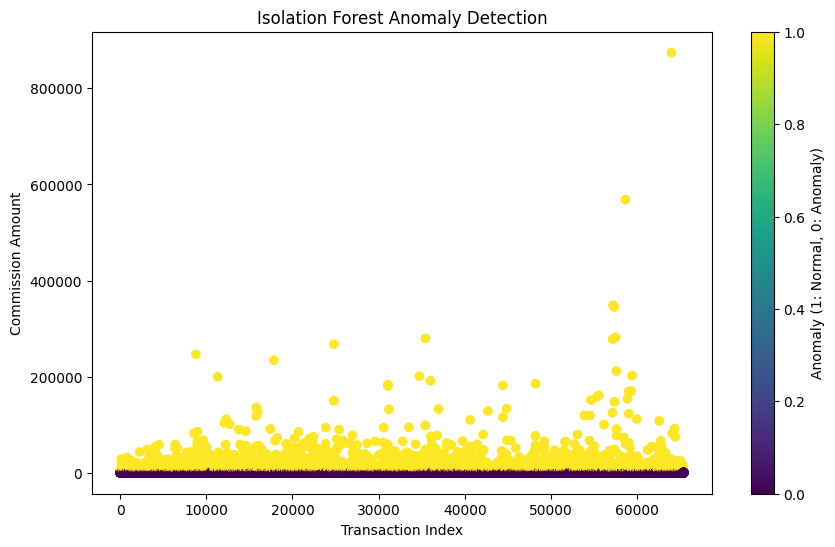

In [ ]:
import matplotlib.pyplot as plt

# Display Isolation Forest result
plt.figure(figsize=(10, 6))
plt.scatter(output.index, output['commissionAmount'], c=output['anomaly_iforest'], cmap='viridis')
plt.title('Isolation Forest Anomaly Detection')
plt.xlabel('Transaction Index')
plt.ylabel('Commission Amount')
plt.colorbar(label='Anomaly (1: Normal, 0: Anomaly)')
plt.show()

**2. Stability Across Parameters:**
- Test the methods with various parameters and observe their sensitivity.
- Consistent results across different parameter settings suggest robustness.
- Inconsistent results may signal that the methods are overly sensitive to input parameters.

In [ ]:
# Example for testing diffrent values for Z-score method
threshold_values = [2, 3, 4, 5]
for threshold in threshold_values:
  result_temp = detect_anomalies(hh, threshold)
  anomaly_counts = result_temp['anomaly_amount'].value_counts()
  print(f"Threshold: {threshold}, Anomaly Counts:\n{anomaly_counts}\n")

Threshold: 2, Anomaly Counts:
anomaly_amount
False    63057
True      2334
Name: count, dtype: int64

Threshold: 3, Anomaly Counts:
anomaly_amount
False    64135
True      1256
Name: count, dtype: int64

Threshold: 4, Anomaly Counts:
anomaly_amount
False    64647
True       744
Name: count, dtype: int64

Threshold: 5, Anomaly Counts:
anomaly_amount
False    64936
True       455
Name: count, dtype: int64



**3. Comparison of Methods:**
- Compare the results of all three methods. Do they identify similar or different anomalies?
- This can help determine if certain anomalies are consistent across methods (potentially being more credible)
- High overlap in anomaly flags across different methods may increase the confidence in the results.
- Visualize the results together (e.g., scatter plot with different colors for each method).

**4. Internal Validation Metrics:**
- Use metrics that are not directly dependent on the ground truth, such as:
 - Silhouette score: measures how similar a data point is to its own cluster compared to other clusters (applicable if we cluster the anomalies)
 - Davies-Bouldin index: measures the average similarity between each cluster and its most similar cluster (applicable for clusters of anomalies)

**5. Consider a Semi-Supervised Approach (If possible):**
- If we can manually label a small subset of the data (even a small sample), we can use that to train a supervised model.
- Then, evaluate the models' performance on the manually-labeled data and try to adjust their thresholds or parameters to improve detection based on that subset.

**Important Considerations:**
* Anomaly detection is highly dependent on the context and business needs.
* There is no one universally correct way to evaluate anomaly detection models in the absence of labels.

In [ ]:
output.head()

createdAt  merchantId  receiveAmount  receiveAssetId  \
0 2024-11-30 17:00:58.076000+00:00    80254491      69.815873             617   
1 2024-11-30 17:00:57.595000+00:00    49465688      65.847413             617   
2 2024-11-30 17:01:54.309000+00:00    13853662     609.360535             617   
3 2024-11-30 17:02:42.391000+00:00    13853662     224.399319             617   
4 2024-11-30 17:03:10.455000+00:00    13853662      99.881955             617   

               tag  commissionAmount    zscore  anomaly_amount  \
0  YY0OYzLMrAeVNr3         69.815873 -0.248262           False   
1  buQtvjpx48ob1cb         65.847413 -0.326616           False   
2  Lm3L6U3OWBGS7cw        609.360535  0.754659           False   
3  2xSzEvmH1lRh1Ac        224.399319 -0.067211           False   
4  ZZbEqEI4D7xl-VV         99.881955 -0.333048           False   

   transaction_count  rolling_mean  rolling_std  zscore_freq  \
0                  2           NaN          NaN          NaN   
1                  7           NaN          NaN          NaN   
2                  3           NaN          NaN          NaN   
3                  3           NaN          NaN          NaN   
4                  3           NaN          NaN          NaN   

   anomaly_frequency  hour  average_hour  hour_diff  anomaly_time  anomaly  \
0              False    17     11.132850   5.867150         False    False   
1              False    17      9.292310   7.707690         False    False   
2              False    17     10.705394   6.294606         False    False   
3              False    17     10.705394   6.294606         False    False   
4              False    17     10.705394   6.294606         False    False   

   anomaly_lof  anomaly_iforest  
0        False            False  
1        False            False  
2        False            False  
3        False            False  
4        False            False